In [3]:
import os
import sys
import tqdm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings('ignore')

# Add your project to path
sys.path.append('/home/nadir/tmr-code')

from src.config import read_config
from src.load import load_model_from_cfg
from hydra.utils import instantiate
import pytorch_lightning as pl

In [4]:
RUN_DIR = "/home/nadir/tmr-code/outputs/multi-class-model-super-super-06-17-10:22"
DEVICE = "cuda:1"
CKPT_NAME = "best"
DATA_DIR = "/home/nadir/windowed-babel-for-classification-for-validation"
MAX_SEQUENCES_TO_ANALYZE = 2048
IOU_DETECTION_THRESHOLD = 0.5

In [5]:
print("[RUN_DIR]:", RUN_DIR)

[RUN_DIR]: /home/nadir/tmr-code/outputs/multi-class-model-super-super-06-17-10:22


In [6]:
cfg = read_config(RUN_DIR)
pl.seed_everything(cfg.seed)

window_size = cfg.data.window_size

model = load_model_from_cfg(cfg, CKPT_NAME, eval_mode=True, device=DEVICE).eval()

dataset = instantiate(
    {
        "_target_": "src.data.windowed_dataset.WindowedDataset",
    },
    dir=DATA_DIR,
    window_size=window_size,
    split="all",
    for_validation=True,
    normalize=False,
    balanced=False
)

normalization_statistics = torch.load(os.path.join(dataset.dir, "motion_normalization_stats.pt"))
mean = normalization_statistics["mean"]
std = normalization_statistics["std"]

print(f"[window-size]: {window_size}")
print(f"[#dataset]: {len(dataset)} sequences.")

Global seed set to 1234


[slef.dir]: /home/nadir/windowed-babel-for-classification-for-validation/20-1
here


[preloading]: 100%|██████████| 1540/1540 [00:00<00:00, 3919.58it/s]

[window-size]: 20
[#dataset]: 1540 sequences.


In [7]:
vote_manager = instantiate({
    "_target_": "src.model.vote_managers.score-based.ScoreBasedVoteManager"
})

In [41]:
def extract_segments(sequence):
    segments = []
    if len(sequence) == 0:
        return segments
    
    current_label = sequence[0]
    start_idx = 0
    
    for i in range(1, len(sequence)):
        if sequence[i] != current_label:
            segments.append((current_label, start_idx, i))
            start_idx = i
            current_label = sequence[i]
    
    # NOTE: add final segment
    segments.append((current_label, start_idx, len(sequence)))
    return segments

def get_action_segments_by_class(sequence, action_class=None, background_class=-1):
    """
    Get segments for a specific action class, or all action segments if class is None.
    Ignores background segments.
    """
    segments = extract_segments(sequence)
    if action_class is None:
        action_segments = [(label, start, end) for label, start, end in segments if label != background_class]
    else:
        action_segments = [(label, start, end) for label, start, end in segments if label == action_class]
    return action_segments

def get_segment_position_in_sequence(start, end, total_length):
    center = (start + end) / 2
    relative_pos = center / total_length
    
    if relative_pos < 0.33:
        return 'beginning'
    elif relative_pos < 0.67:
        return 'middle'
    else:
        return 'end'

def categorize_segment_length(number_of_frames):
    if number_of_frames <= 2*20:
        return 'short'
    elif number_of_frames <= 4.5*20:
        return 'medium'
    else:
        return 'long'

def categorize_sequence_length(length):
    if length <= 8*20:
        return 'short'
    elif length <= 14*20:
        return 'medium'
    else:
        return 'long'

def calculate_segment_iou(segment_1_start, segment_1_end, segment_2_start, segment_2_end):
    """
    Calculate IoU between two segments.
    """
    intersection = max(0, min(segment_1_end, segment_2_end) - max(segment_1_start, segment_2_start))
    union = max(segment_1_end, segment_2_end) - min(segment_1_start, segment_2_start)
    return intersection / union if union > 0 else 0

In [42]:
idx2als = {
    -1: ['unknown'],
    0: ['walk'],
    1: ['hit', 'punch'],
    2: ['kick'],  # Really short action segments?
    3: ['run', 'jog'],
    4: ['jump', 'hop', 'leap'],
    5: ['throw'],
    6: ['catch'],
    7: ['step'],
    8: ['greet'],  # Large diversity expected
    9: ['dance'],
    10: ['stretch', 'yoga', 'exercise / training'],  # Large diversity expected
    11: ['turn', 'spin'],  # Is this distinct enough from take / pick something up? Yeah, I think so.
    12: ['bend'],
    13: ['stand'],  # Large diversity expected
    14: ['sit'],
    15: ['kneel'],
    16: ['place something'],
    17: ['grasp object'],
    18: ['take/pick something up', 'lift something'],
    19: ['scratch', 'touching face', 'touching body parts'],
}
als2idx = {}

for idx, aliases in idx2als.items():
    for alias in aliases:
        als2idx[alias] = idx

In [43]:
results = []

all_groundtruths, all_predictions = [], []
all_confidence_scores = []

with torch.no_grad():
    for idx in tqdm.tqdm(iterable=range(min(len(dataset), MAX_SEQUENCES_TO_ANALYZE)), total=min(len(dataset), MAX_SEQUENCES_TO_ANALYZE), desc="[segmentation-analysis]"):
        sample = dataset[idx]
        
        sample["transformed_motion"] = sample["transformed_motion"].to(DEVICE)
        sample["motion"] = sample["motion"].to(DEVICE)
        sample["annotation"] = sample["annotation"]
        
        groundtruth = sample["annotation"].cpu().numpy()
        
        outputs, exception = model.segment_sequence(
            sample,
            window_size=window_size,
            window_step=1,
            vote_manager=vote_manager,
            mean=mean,
            std=std
        )
        
        if exception is not None:
            print(f"[warning]: skipped {idx}: {exception}")
            continue
        
        prediction = outputs.cpu().numpy()
        
        all_predictions.append(prediction)
        all_groundtruths.append(groundtruth)
        
        sequence_length = len(groundtruth)
        
        groundtruth_segments = get_action_segments_by_class(groundtruth)
        predicted_segments = get_action_segments_by_class(prediction)
        
        frame_accuracy = np.mean(prediction == groundtruth)
        
        # NOTE: analyze each ground truth segment
        for groundtruth_label, groundtruth_start, groundtruth_end in groundtruth_segments:
            groundtruth_length = groundtruth_end - groundtruth_start
            groundtruth_position = get_segment_position_in_sequence(groundtruth_start, groundtruth_end, sequence_length)
            
            best_iou = 0
            best_pred_segment = (None, None, None)
            detected = False
            class_matched = False
            
            # NOTE: find best matching segment and its predicted class
            for predicted_label, predicted_start, predicted_end in predicted_segments:
                iou = calculate_segment_iou(groundtruth_start, groundtruth_end, predicted_start, predicted_end)
                
                if iou > best_iou:
                    best_iou = iou
                    best_pred_segment = (predicted_label, predicted_start, predicted_end)
                    
                if iou > IOU_DETECTION_THRESHOLD:
                    detected = True
                    if predicted_label == groundtruth_label:
                        class_matched = True
            
            result = {
                'sequence_idx': idx,
                'sequence_length': sequence_length,
                'sequence_length_cat': categorize_sequence_length(sequence_length),
                'frame_accuracy': frame_accuracy,
                'gt_class': groundtruth_label,
                'gt_class_name': ",".join(idx2als[groundtruth_label]) if groundtruth_label < len(idx2als) else f'class_{groundtruth_label}',
                'gt_start': groundtruth_start,
                'gt_end': groundtruth_end,
                'gt_length': groundtruth_length,
                'gt_length_cat': categorize_segment_length(groundtruth_length),
                'gt_position': groundtruth_position,
                'detected': detected,
                'class_matched': class_matched,
                'best_iou': best_iou,
                'num_gt_segments': len(groundtruth_segments),
                'num_pred_segments': len(predicted_segments),
            }
            
            if best_pred_segment:
                predicted_label, predicted_start, predicted_end = best_pred_segment
                result['pred_class'] = predicted_label
                result['pred_class_name'] = idx2als[predicted_label] if predicted_label < len(idx2als) else f'class_{predicted_label}'
                result['pred_start'] = predicted_start
                result['pred_end'] = predicted_end
                result['pred_length'] = predicted_end - predicted_start
                result['pred_length_cat'] = categorize_segment_length(result['pred_length'])
            else:
                result['pred_class'] = None
                result['pred_class_name'] = None
                result['pred_start'] = None
                result['pred_end'] = None
                result['pred_length'] = None
                result['pred_length_cat'] = None
            
            results.append(result)

print(f"[#segments-analyzed]: {len(results)}")

dataframe = pd.DataFrame(results)

[segmentation-analysis]:   0%|          | 0/1540 [00:00<?, ?it/s]

[segmentation-analysis]: 100%|██████████| 1540/1540 [00:21<00:00, 70.89it/s] 

[#segments-analyzed]: 2932


1 49.94304229195089 479


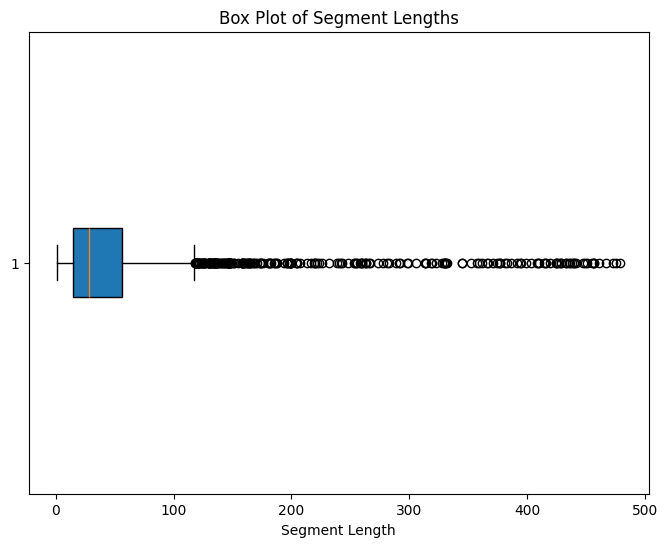

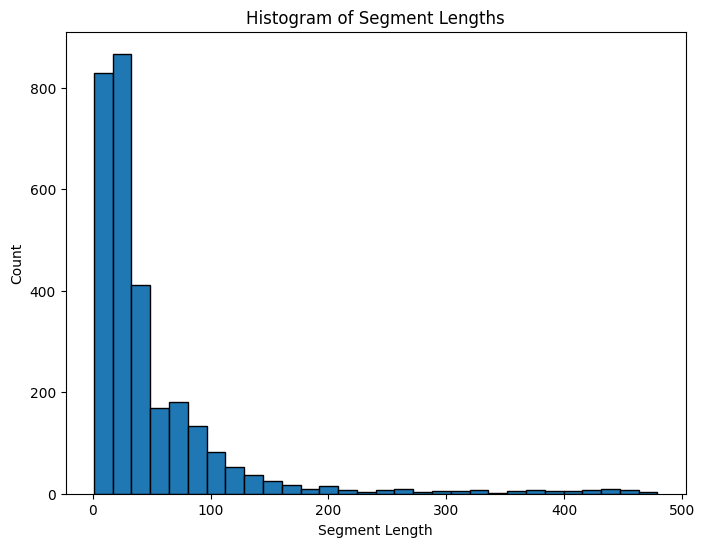

In [44]:
lengths = [result['gt_length'] for result in results]

print(np.min(lengths), np.average(lengths), np.max(lengths))

plt.figure(figsize=(8, 6))
plt.boxplot(lengths, vert=False, patch_artist=True)
plt.xlabel('Segment Length')
plt.title('Box Plot of Segment Lengths')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(lengths, bins=30, edgecolor='black')
plt.xlabel('Segment Length')
plt.ylabel('Count')
plt.title('Histogram of Segment Lengths')
plt.show()

In [45]:
idx2als = {
    -1: ['ignored'],
    0: ['walk'],
    1: ['hit', 'punch'],
    2: ['kick'],
    3: ['run', 'jog'],
    4: ['jump', 'hop', 'leap'],
    5: ['throw'],
    6: ['catch'],
    7: ['step'],
    8: ['greet'],
    9: ['dance'],
    10: ['stretch', 'yoga', 'exercise / training'],
    11: ['turn', 'spin'],
    12: ['bend'],
    13: ['stand'],
    14: ['sit'],
    15: ['kneel'],
    16: ['place something'],
    17: ['grasp object'],
    18: ['take/pick something up', 'lift something'],
    19: ['scratch', 'touching face', 'touching body parts'],
}
idx2alssss = [",".join(value) for value in idx2als.values()]

<div class="alert alert-info">

$\text{Precision} = \frac{\text{True Positive}}{\text{True Positives} + \text{False Positives}}$

Tells: "Of all the times the model predicted this class, how many times was it correct.

$\text{Recall} = \frac{\text{True Positive}}{\text{True Positives} + \text{False Negatives}}$

Tells: "Of all the true instances of this class, how many did the model correctly identify ?"

F1 score is the harmonic mean of the precision and recall; It is high if both precision and recall are high and 0 if either of them is 0.

The macro average is used for multiclass classification problems and it consist of taking the average of the precision or recall for each class.

</div>

In [47]:
flat_predictions = np.concatenate(all_predictions)
flat_groundtruths = np.concatenate(all_groundtruths)

overall_accuracy = np.mean(flat_predictions == flat_groundtruths)
confusion = confusion_matrix(flat_groundtruths, flat_predictions)
class_report = classification_report(flat_groundtruths, flat_predictions, target_names=idx2als, output_dict=True, zero_division=0)

<div class="alert alert-info">

**Per class performance**.

</div>

[frame-wise-accuracy]: 0.515
--- --- ---
[Per-class Performance]:
	ignored: precision=0.000; recall=0.000; F1=0.000; support=67895.0
	walk: precision=0.723; recall=0.919; F1=0.810; support=61809.0
	hit,punch: precision=0.033; recall=0.153; F1=0.054; support=399.0
	kick: precision=0.525; recall=0.647; F1=0.580; support=3558.0
	run,jog: precision=0.870; recall=0.905; F1=0.888; support=14400.0
	jump,hop,leap: precision=0.671; recall=0.829; F1=0.742; support=6621.0
	throw: precision=0.345; recall=0.662; F1=0.453; support=3127.0
	catch: precision=0.081; recall=0.411; F1=0.136; support=397.0
	step: precision=0.343; recall=0.517; F1=0.413; support=5894.0
	greet: precision=0.402; recall=0.770; F1=0.529; support=2901.0
	dance: precision=0.275; recall=0.578; F1=0.373; support=5516.0
	stretch,yoga,exercise / training: precision=0.115; recall=0.366; F1=0.174; support=3456.0
	turn,spin: precision=0.267; recall=0.329; F1=0.295; support=4955.0
	bend: precision=0.050; recall=0.138; F1=0.074; support=8

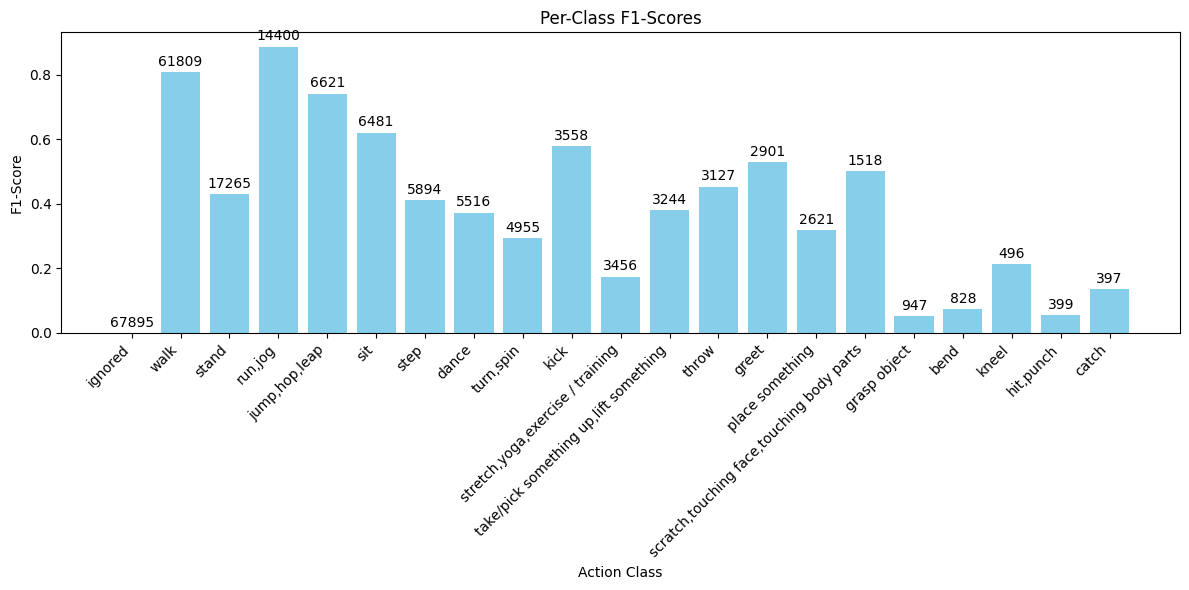

In [48]:
print(f"[frame-wise-accuracy]: {overall_accuracy:.3f}")

print(f"--- --- ---")

print("[Per-class Performance]:")

# Prepare data for the bar plot
class_names, f1_scores, supports = [], [], []

for i, class_name in enumerate(idx2als):
    if class_name in class_report:
        precision = class_report[class_name]['precision']
        recall = class_report[class_name]['recall']
        f1 = class_report[class_name]['f1-score']
        support = class_report[class_name]['support']
        
        class_names.append(','.join(idx2als[class_name]))
        f1_scores.append(f1)
        supports.append(support)
        
        print(f"\t{','.join(idx2als[class_name])}: precision={precision:.3f}; recall={recall:.3f}; F1={f1:.3f}; support={support}")

data = list(zip(class_names, f1_scores, supports))
data.sort(key=lambda x: x[2], reverse=True)
class_names, f1_scores, supports = zip(*data)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, f1_scores, color='skyblue')
plt.xlabel('Action Class')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Scores')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for bar, support in zip(bars, supports):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, int(support), ha='center', va='bottom')

plt.show()

In [49]:
print(f"[macro-avg-precision]: {class_report['macro avg']['precision']:.3f}")
print(f"[macro-avg-recall]: {class_report['macro avg']['recall']:.3f}")
print(f"[macro-avg-f1]: {class_report['macro avg']['f1-score']:.3f}")
print(f"[weighted-avg-f1]: {class_report['weighted avg']['f1-score']:.3f}")

[macro-avg-precision]: 0.319
[macro-avg-recall]: 0.508
[macro-avg-f1]: 0.383
[weighted-avg-f1]: 0.438


<div class="alert alert-info">

**Detection rate**, **Overall class match rate**, **Class match rate given detection**.

</div>

In [50]:
detection_rate = dataframe['detected'].mean()
class_match_rate = dataframe['class_matched'].mean()
class_match_rate_given_detected = dataframe[dataframe['detected']]['class_matched'].mean()

print(f"[segment-detection-rate-(IoU > {IOU_DETECTION_THRESHOLD})]: {detection_rate:.3f}")
print(f"[class-match-rate-(overall)]: {class_match_rate:.3f}")
print(f"[class-match-rate-(given-detected)]: {class_match_rate_given_detected:.3f}")

[segment-detection-rate-(IoU > 0.5)]: 0.625
[class-match-rate-(overall)]: 0.525
[class-match-rate-(given-detected)]: 0.840


<div class="alert alert-info">

**Average IoU for detected segments**

The higher, the more aligned our detections are and the better it is.

</div>

In [51]:
avg_iou_detected = dataframe[dataframe['detected']]['best_iou'].mean()
print(f"[average-iou-for-detected-segments]: {avg_iou_detected:.3f}")

[average-iou-for-detected-segments]: 0.800


<div class="alert alert-info">

**Segment Count Accuracy**

The higher the better as it means our model correctly guess the number of different segments present in the motion.

</div>

In [52]:
segment_count_accuracy = []

for prediction, groundtruth in zip(all_predictions, all_groundtruths):
    groundtruth_count = len(get_action_segments_by_class(groundtruth))
    prediction_count = len(get_action_segments_by_class(prediction))
    
    if groundtruth_count > 0:
        accuracy = 1.0 - abs(prediction_count - groundtruth_count) / groundtruth_count
    else:
        accuracy = 1.0 if prediction_count == 0 else 0.0
        
    segment_count_accuracy.append(accuracy)

print(f"[segment-count-accuracy]: {np.mean(segment_count_accuracy):.3f}")

[segment-count-accuracy]: 0.060


<div class="alert alert-info">

Analysis of results by **Segment Length**

</div>

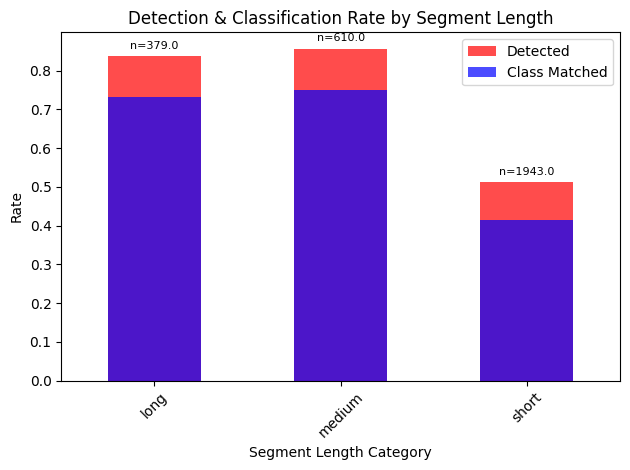

In [53]:
detection_by_length = dataframe.groupby('gt_length_cat')[['detected', 'class_matched']].agg(['mean', 'count'])
detection_by_length[('detected', 'mean')].plot(kind='bar', color='red', alpha=0.7, label='Detected')
detection_by_length[('class_matched', 'mean')].plot(kind='bar', color='blue', alpha=0.7, label='Class Matched')

plt.title('Detection & Classification Rate by Segment Length')

plt.ylabel('Rate')
plt.xlabel('Segment Length Category')

plt.tick_params(axis='x', rotation=45)

plt.legend()

for i, (idx, row) in enumerate(detection_by_length.iterrows()):
    plt.text(i, row[('detected', 'mean')] + 0.02, f'n={row["detected"]["count"]}', ha='center', fontsize=8)
    
plt.tight_layout()

plt.show()

<div class="alert alert-info">

Analysis of results by **Segment Position**

</div>

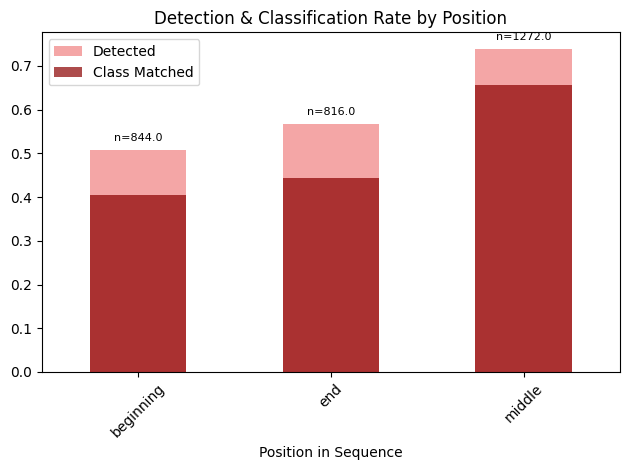

In [57]:
detection_by_position = dataframe.groupby('gt_position')[['detected', 'class_matched']].agg(['mean', 'count'])
detection_by_position[('detected', 'mean')].plot(kind='bar', color='lightcoral', alpha=0.7, label='Detected')
detection_by_position[('class_matched', 'mean')].plot(kind='bar', color='darkred', alpha=0.7, label='Class Matched')

plt.title('Detection & Classification Rate by Position')

plt.xlabel('Position in Sequence')

plt.tick_params(axis='x', rotation=45)

plt.legend()

for i, (idx, row) in enumerate(detection_by_position.iterrows()):
    plt.text(i, row[('detected', 'mean')] + 0.02, f'n={row["detected"]["count"]}', ha='center', fontsize=8)
    
plt.tight_layout()

plt.show()

<div class="alert alert-info">

Analysis of results by **Action**

</div>

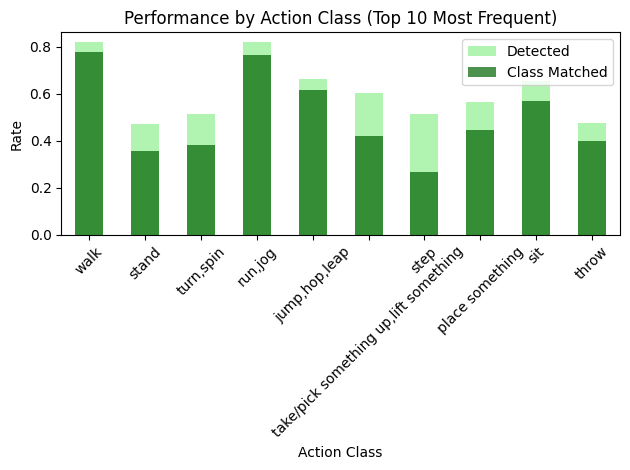

In [59]:
class_performance = dataframe.groupby('gt_class_name')[['detected', 'class_matched']].agg(['mean', 'count']).round(3)
class_performance = class_performance.sort_values(('detected', 'count'), ascending=False).head(10)
class_performance[('detected', 'mean')].plot(kind='bar', color='lightgreen', alpha=0.7, label='Detected')
class_performance[('class_matched', 'mean')].plot(kind='bar', color='darkgreen', alpha=0.7, label='Class Matched')

plt.title('Performance by Action Class (Top 10 Most Frequent)')

plt.ylabel('Rate')
plt.xlabel('Action Class')

plt.tick_params(axis='x', rotation=45)

plt.legend()

plt.tight_layout()

plt.show()